### EXP: Full launch QC rating 

- **Aim:** First full launch of quality control (QC) of brain registration on the Zooniverse platform. Raters are some of zooniverse users ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 and COBRE datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [154]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [155]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [156]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [157]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [158]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [159]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Start Project 1'])]
ratings.count()

classification_id    4351
user_name            4351
user_id              3718
user_ip              4351
workflow_id          4351
workflow_name        4351
workflow_version     4351
created_at           4351
gold_standard           0
expert                  0
metadata             4351
annotations          4351
subject_data         4351
subject_ids          4351
dtype: int64

In [160]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]

# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]

# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]

# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]


In [161]:
# Extract two expert raters ('colezweber','ppf') and save them for after  
expert_ = ratings[ratings.user_name.isin([ 'colezweber','ppf','jenichen'])]
# Save to csv
expert_.to_csv('../data/rating/Full_launch1_ppf-colezweber.csv',index=False)

In [162]:
# Remove 3 experts and one outlier
ratings = ratings[~ratings.user_name.isin(['jenichen','colezweber','ppf','willy71'])]

In [163]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count.head()

MsImmortal         126
lobusparietalis    105
1010101            103
alinanaseer        103
sueburr            102
Name: user_name, dtype: int64

In [164]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=20]
user_count[list_user]

MsImmortal                            126
lobusparietalis                       105
1010101                               103
alinanaseer                           103
sueburr                               102
rubyadeline                           100
RLINDS4026                            100
Uganalandia                           100
hallkr                                 99
narguedasn                             95
ashherr17                              92
juliejo                                87
kitchenmi                              69
AlyPereira21                           67
PeterZXY                               63
ChaoticK                               54
Michaelspili                           54
not-logged-in-4d11726c1f714afe8e57     50
alyssalewis4                           50
Dillen                                 49
1a2r3u4n                               45
not-logged-in-7715f3dcb14df1943100     44
AndrejGalinac                          44
Hmelting                          

In [165]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    2393
user_name            2393
user_id              2205
user_ip              2393
workflow_id          2393
workflow_name        2393
workflow_version     2393
created_at           2393
gold_standard           0
expert                  0
metadata             2393
annotations          2393
subject_data         2393
subject_ids          2393
n_tagging            2393
rating               2393
ID                   2393
imgnm                2393
dtype: int64

In [166]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

hallkr have 1 duplicated ratings
1a2r3u4n have 2 duplicated ratings
MsImmortal have 26 duplicated ratings
not-logged-in-bd56c1b642fe9a396968 have 3 duplicated ratings
lobusparietalis have 5 duplicated ratings
Dillen have 1 duplicated ratings
not-logged-in-7715f3dcb14df1943100 have 8 duplicated ratings
ritu99 have 1 duplicated ratings
1010101 have 3 duplicated ratings
not-logged-in-1482d11fba86b2ce0126 have 1 duplicated ratings
kitchenmi have 1 duplicated ratings
sueburr have 2 duplicated ratings
not-logged-in-b7ef785608cf8dff0161 have 5 duplicated ratings
not-logged-in-4d11726c1f714afe8e57 have 12 duplicated ratings
ashherr17 have 16 duplicated ratings
alinanaseer have 39 duplicated ratings
AlyPereira21 have 23 duplicated ratings
alyssalewis4 have 1 duplicated ratings
PeterZXY have 32 duplicated ratings
adamsmadison1 have 2 duplicated ratings
Total number of duplicated ratings  = 184


In [167]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

lobusparietalis                       100
MsImmortal                            100
RLINDS4026                            100
sueburr                               100
Uganalandia                           100
1010101                               100
rubyadeline                           100
hallkr                                 98
narguedasn                             95
juliejo                                87
ashherr17                              76
kitchenmi                              68
alinanaseer                            64
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           49
Dillen                                 48
AlyPereira21                           44
AndrejGalinac                          44
1a2r3u4n                               43
Hmelting                               41
sanitha.yang                           39
Service55                              39
not-logged-in-4d11726c1f714afe8e57

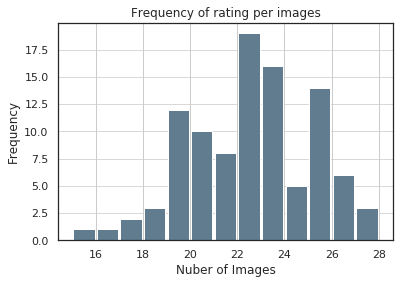

In [169]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [170]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,lobusparietalis,MsImmortal,RLINDS4026,sueburr,Uganalandia,1010101,rubyadeline,hallkr,narguedasn,...,not-logged-in-fd113a44caf2be51959e,not-logged-in-1482d11fba86b2ce0126,LeonLiu,FemkeLara,Jardy57,jimin9435,enehta,ritu99,not-logged-in-bd56c1b642fe9a396968,not-logged-in-b7ef785608cf8dff0161
0,X1743472,Maybe,Fail,Maybe,Maybe,Fail,Maybe,Fail,Fail,Maybe,...,NaN,Fail,NaN,NaN,Fail,OK,NaN,NaN,NaN,NaN
1,X3662296,Maybe,Fail,Fail,Maybe,Maybe,OK,OK,Fail,Maybe,...,NaN,NaN,NaN,Fail,NaN,OK,NaN,Maybe,NaN,NaN
2,X2443191,OK,OK,Maybe,Fail,OK,OK,OK,OK,OK,...,Fail,NaN,NaN,OK,NaN,NaN,NaN,OK,Fail,NaN
3,HC0040055,OK,OK,OK,Maybe,OK,OK,OK,Maybe,OK,...,Fail,Maybe,NaN,OK,OK,OK,NaN,NaN,NaN,NaN
4,X4104523,Maybe,Fail,Fail,Maybe,Fail,Fail,OK,OK,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,NaN,Maybe


In [171]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [172]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X1743472,15,7,4
1,X3662296,9,11,6
2,X2443191,3,3,14
3,HC0040055,3,6,18
4,X4104523,7,10,4


In [19]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X1743472,0.576923,0.269231,0.153846,0.576923,Fail
1,X3662296,0.346154,0.423077,0.230769,0.423077,Maybe
2,X2443191,0.15,0.15,0.7,0.700000,OK
3,HC0040055,0.111111,0.222222,0.666667,0.666667,OK
4,X4104523,0.333333,0.47619,0.190476,0.476190,Maybe


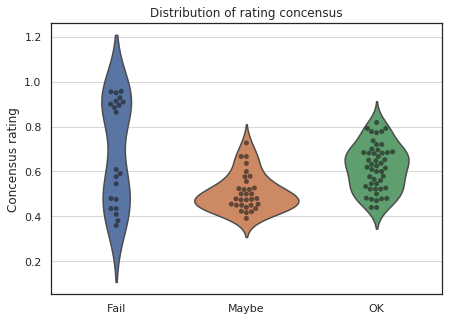

In [20]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')
plt.savefig('../reports/figures/concensus_zooniverse.svg')

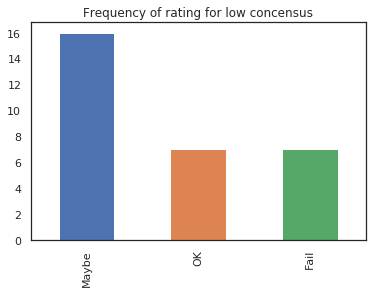

In [21]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

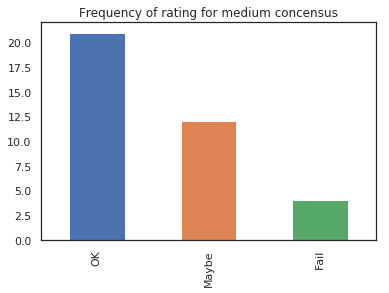

In [22]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

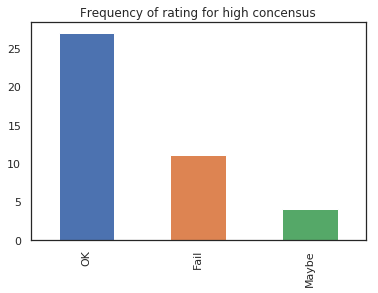

In [23]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [173]:
# Save a copy of concensus
df_norm[['ID','max_value_NoExp','concensus_NoExp']].rename(columns={'concensus_NoExp':'Zcon','max_value_NoExp':'ZconVal'}).to_csv('../data/rating/full_launch_zooniverse_consensus.csv',index=False)

In [174]:
df_norm[df_norm['concensus_NoExp'] == 'Maybe']

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
1,X3662296,0.346154,0.423077,0.230769,0.423077,Maybe
4,X4104523,0.333333,0.47619,0.190476,0.476190,Maybe
7,X2876903,0.136364,0.454545,0.409091,0.454545,Maybe
10,X3611827,0.0869565,0.478261,0.434783,0.478261,Maybe
11,X0021015,0.166667,0.416667,0.416667,0.416667,Maybe
15,X2054998,0.08,0.48,0.44,0.480000,Maybe
16,X3902469,0.0526316,0.578947,0.368421,0.578947,Maybe
20,X1038415,0.2,0.45,0.35,0.450000,Maybe
35,X0026039,0.0526316,0.473684,0.473684,0.473684,Maybe
37,X3848511,0.0952381,0.666667,0.238095,0.666667,Maybe


### Merge Pilot3 and Full launch 1 rating and get Kappa score

In [26]:
pilot3 = pd.read_csv('../data/rating/Pilot3_internal_rating.csv')
pilot3.head()

,ID,Yben,Pbel,Bpin,Sdup,Atam,Mpel,Bdel,Cons_P3
0,SZ0040029,OK,Maybe,OK,Maybe,OK,Fail,Maybe,Maybe
1,SZ0040039,OK,OK,Fail,OK,Maybe,OK,OK,OK
2,SZ0040042,OK,OK,Maybe,Maybe,OK,Fail,OK,Maybe
3,SZ0040044,OK,OK,Fail,OK,OK,Maybe,OK,OK
4,SZ0040046,OK,OK,Maybe,Maybe,OK,Maybe,OK,Maybe


In [27]:
# Merge 
merge_ratings = pd.merge(pilot3,df_norm[['ID','concensus_NoExp']],on='ID',how='inner').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
merge_ratings.rename(columns={'concensus_NoExp':'Cons_F1'},inplace=True)
merge_ratings.head()

,ID,Yben,Pbel,Bpin,Sdup,Atam,Mpel,Bdel,Cons_P3,Cons_F1
0,X0026002,Maybe,Maybe,Fail,Fail,Maybe,Maybe,Maybe,Maybe,Maybe
1,X3848511,Maybe,Maybe,Fail,Maybe,Maybe,Maybe,Maybe,Maybe,Maybe
2,X3107623,OK,OK,OK,Maybe,Maybe,Maybe,Fail,Maybe,OK
3,X3433846,Maybe,Maybe,Fail,Fail,Maybe,OK,Fail,Fail,OK
4,X3163200,Maybe,OK,Fail,OK,Maybe,Fail,Maybe,Fail,Maybe


In [28]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
merge_ratings.rename(columns={'bpinsard':'Bpin',
                              'saradupont':'Sdup',
                              'angelatam':'Atam',
                              'hereinlies':'Mpel',
                              'benjamindeleener':'Bdel'},inplace=True)
merge_ratings = merge_ratings[['ID','Yben','Pbel','Atam','Bdel','Sdup','Mpel','Bpin','Cons_F1']]
merge_ratings.head()

,ID,Yben,Pbel,Atam,Bdel,Sdup,Mpel,Bpin,Cons_F1
0,X0026002,2,2,2,2,3,2,3,2
1,X3848511,2,2,2,2,2,2,3,2
2,X3107623,1,1,2,3,2,2,1,1
3,X3433846,2,2,2,3,3,1,3,1
4,X3163200,2,1,2,2,1,3,3,2


In [29]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lpSolve

  warnings.warn(x, RRuntimeWarning)


In [30]:
# Percenteage of agrrement between raters with R package IRR
agree_ = merge_ratings.drop(['ID'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 29 
   Raters = 8 
  %-agree = 31 



In [31]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [32]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [33]:
# Get Kappa score out of all different combination of ratings
kappa_df  = merge_ratings.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.39 , std : 0.19

 Fleiss' Kappa for m Raters

 Subjects = 29 
   Raters = 8 
    Kappa = 0.37 

        z = 12.8 
  p-value = 0 



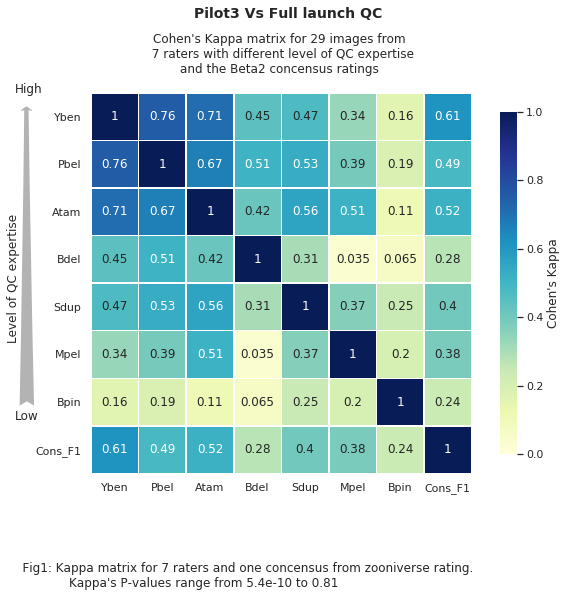

In [34]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (10,7))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot3 Vs Full launch QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for {} images from \n  7 raters with different level of QC expertise \n and the Beta2 concensus ratings  ".format(len(merge_ratings)),
               pad=20,fontsize=12)
axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, 0.14), xycoords='axes fraction',
              arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            fc="0.7", ec="none",
                            linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters and one concensus from zooniverse rating.
                Kappa's P-values range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12)
f.text(0.11,0.88,'High',fontsize=12)
f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Full-Launch-vs-pilot3_qc.svg')

In [35]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Full lanch 1 raters

In [42]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'cons' = c.m'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X3912996,Start Project 1,rubyadeline,Maybe,285.96875,199.0,1.5,2,X_3912996_anat.png,0
1,X3912996,Start Project 1,rubyadeline,Maybe,313.96875,556.0,1.5,2,X_3912996_anat.png,0
2,X0023019,Start Project 1,rubyadeline,OK,NaN,NaN,NaN,0,X_0023019_anat.png,1
3,X0021014,Start Project 1,rubyadeline,Fail,69.96875,75.0,1.5,51,X_0021014_anat.png,0
4,X0021014,Start Project 1,rubyadeline,Fail,103.96875,62.0,1.5,51,X_0021014_anat.png,0


In [69]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm = df_ids_imgnm.merge(df_norm[['ID','max_value_NoExp','concensus_NoExp']], on='ID')
df_ids_imgnm.head()

,ID,imgnm,max_value_NoExp,concensus_NoExp
0,HC0040038,HC0040038_anat.png,0.791667,OK
1,HC0040043,HC0040043_anat.png,0.600000,OK
2,HC0040045,HC0040045_anat.png,0.545455,OK
3,HC0040048,HC0040048_anat.png,0.440000,OK
4,HC0040050,HC0040050_anat.png,0.478261,OK


In [149]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [150]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

In [79]:
# Populate patches
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row_.x,row_.y,row.max_value_NoExp,row.concensus_NoExp) for ind,row_ in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']
patches_df = pd.DataFrame(patches, columns=['x','y','cons','rate'])
patches_df.head()

,x,y,cons,rate
0,100.000000,297.0,0.791667,OK
1,508.000000,586.0,0.791667,OK
2,121.303444,281.0,0.791667,OK
3,94.468750,298.0,0.791667,OK
4,316.468750,302.0,0.791667,OK


### Plot all tagging

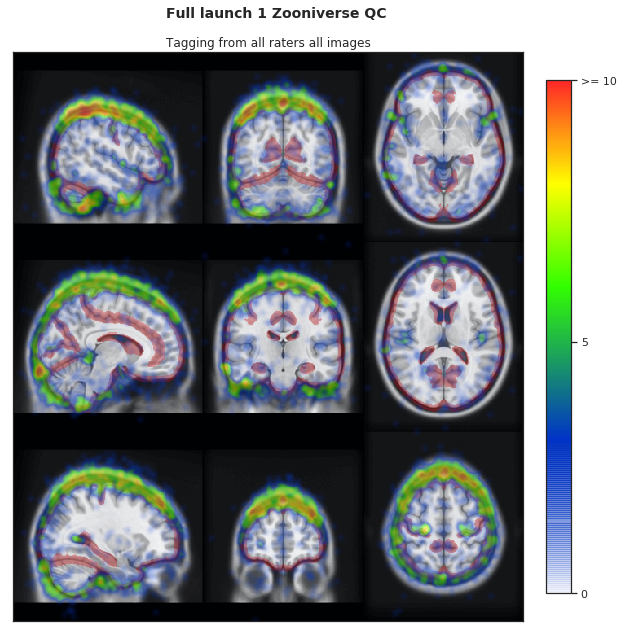

In [94]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters all images')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.1,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches_df[['x','y']].as_matrix(), img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '>= 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_qc_heatmap_tags.svg')

### Compare kappa within non-expert from full launch 1

### Plot maybe image tagging

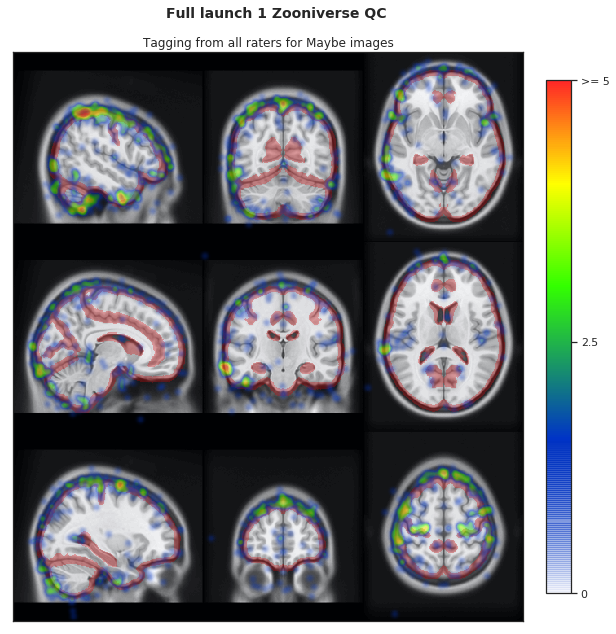

In [152]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters for Maybe images')

#select specific patches
patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == 'Maybe' and rr.cons >= 0 ]
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.2,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '2.5', '>= 5'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_qc_heatmap_Maybe_tags.svg')


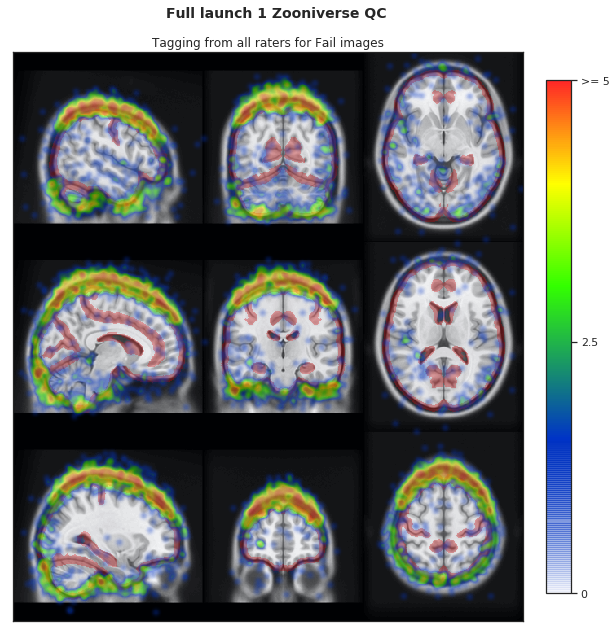

In [153]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters for Fail images')

#select specific patches
patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == 'Fail' and rr.cons >= 0 ]
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.2,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '2.5', '>= 5'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_qc_heatmap_Fail_tags.svg')


In [122]:
# How many rating per user
user_count = classi_unique.user_name.value_counts()
user_count

rubyadeline                           100
1010101                               100
Uganalandia                           100
sueburr                               100
MsImmortal                            100
RLINDS4026                            100
lobusparietalis                       100
hallkr                                 98
narguedasn                             95
juliejo                                87
ashherr17                              76
kitchenmi                              68
alinanaseer                            64
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           49
Dillen                                 48
AlyPereira21                           44
AndrejGalinac                          44
1a2r3u4n                               43
Hmelting                               41
sanitha.yang                           39
Service55                              39
not-logged-in-4d11726c1f714afe8e57

In [123]:
# Select only raters how completed 100 images
list_user = user_count.index
list_user = list_user[user_count.values==100]
user_count[list_user]

rubyadeline        100
1010101            100
Uganalandia        100
sueburr            100
MsImmortal         100
RLINDS4026         100
lobusparietalis    100
Name: user_name, dtype: int64

In [124]:
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings_F1 = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating).apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_ratings_F1.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_ratings_F1.head()

,ID,rubyadeline,1010101,Uganalandia,sueburr,MsImmortal,RLINDS4026,lobusparietalis
0,X3912996,2,1,2,2,2,2,1
1,X0023019,1,1,2,2,2,2,2
2,X0021014,3,3,1,3,3,3,3
3,HC0040053,2,1,2,1,2,3,1
4,X1038415,1,3,1,2,2,3,1


In [125]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings_F1.drop(columns='ID',axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 7 
  %-agree = 12 



In [126]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings_F1.drop(columns='ID',axis=1)
kappa_df.rename(columns={'1010101':'X1010101'},inplace=True)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.29 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 7 
    Kappa = 0.195 

        z = 12.5 
  p-value = 0 



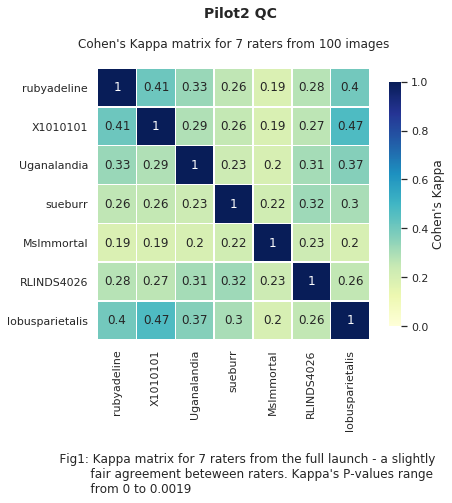

In [127]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 7 raters from {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters from the full launch - a slightly 
            fair agreement beteween raters. Kappa's P-values range 
            from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.3,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/full_launch1_qc.svg')

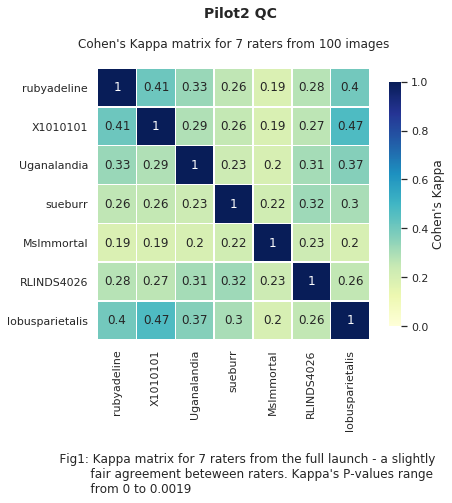

In [128]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 7 raters from {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters from the full launch - a slightly 
            fair agreement beteween raters. Kappa's P-values range 
            from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.3,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/full_launch1_qc.svg')